In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved training-set waveforms

In [4]:
#trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015.hdf5')
trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015_n1056.hdf5')
trainset = ws.HDF5WaveformSet('../data/dh_training_set_join_p00015.hdf5')
len(trainset)

260

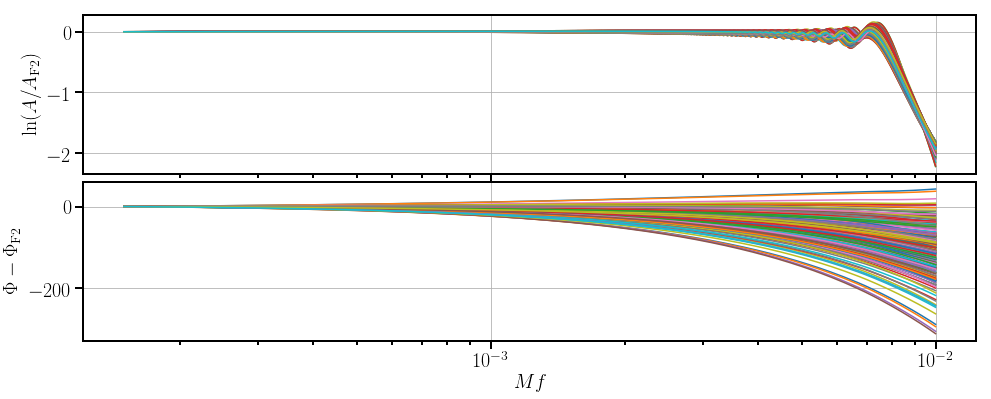

In [5]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate reduced Bases for amplitude and phase

In [6]:
epsilon = 1.0e-6

# Initialize the ReducedBasis object
add = surrogate.add_amp
subtract = surrogate.subtract_amp
scalar_multiply = surrogate.scalar_multiply_amp
inner_product = surrogate.inner_product_amp

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbamprun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbamprun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.0452128614297
0.00694435680942
0.00508494775753
0.00122086056004
0.000995443163874
0.000575216413555
0.000314724177414
0.000180473732207
0.00010765331537
0.000104129356048
5.51155730429e-05
4.24491203174e-05
3.89872546971e-05
2.02096342077e-05
1.53605694549e-05
1.43727673808e-05
1.36370820799e-05
9.41817776423e-06
5.9094347552e-06
5.7003891164e-06
4.8043829427e-06
3.98505800014e-06
3.25297814741e-06
2.98689095146e-06
2.57364550549e-06
2.46681221749e-06
1.7818842728e-06
1.3585224089e-06
1.01675160624e-06
9.2723599765e-07


In [7]:
len(rbamprun.rb)

31

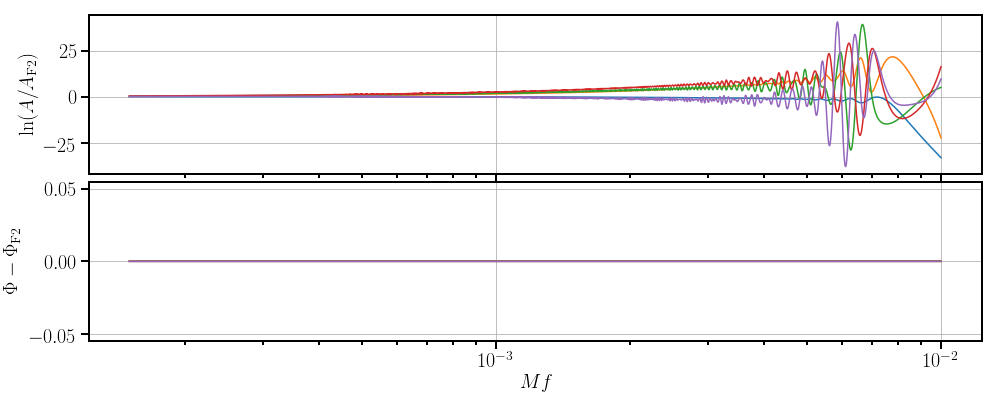

In [8]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(rbamprun.rb[:5])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

In [9]:
epsilon = 1.0e-10

# Initialize the ReducedBasis object
add = surrogate.add_phase
subtract = surrogate.subtract_phase
scalar_multiply = surrogate.scalar_multiply_phase
inner_product = surrogate.inner_product_phase

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbphaserun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbphaserun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.908992584114
0.00425671300592
0.000235596187988
2.77779538242e-05
6.07858111656e-06
4.4760814264e-06
7.27562736391e-07
4.19898746551e-07
2.85553133583e-07
1.7275747477e-07
1.31954491889e-07
9.96764824013e-08
7.07536806921e-08
5.43489067084e-08
3.78783471255e-08
1.41725651215e-08
1.1834158653e-08
9.14650077899e-09
7.8730478803e-09
7.63206009502e-09
7.60867879812e-09
3.18529835841e-09
1.66917435429e-09
1.48737255845e-09
1.05944109041e-09
6.44903574987e-10
6.38306074663e-10
4.45971704011e-10
4.22749502071e-10
3.83613252275e-10
3.23657767254e-10
2.18110529637e-10
2.10349737628e-10
1.7430712429e-10
1.60563340401e-10
1.27843069464e-10
1.22881038678e-10
1.01716746137e-10
9.73580105423e-11


In [10]:
len(rbphaserun.rb)

40

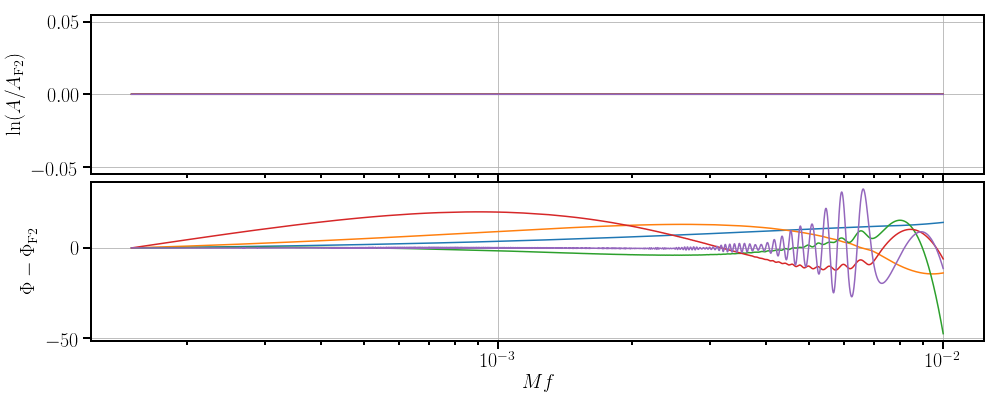

In [11]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(rbphaserun.rb[:5])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Empirical interpolating functions

In [12]:
def save_empirical_interpolating_function_list(filename, b_j, mf_node):
    """Save the empirical interpolating functions as a HDF5WaveformSet object.
    """
    bset = ws.HDF5WaveformSet(filename)
    
    for j in range(len(b_j)):
        # b_j don't have waveform parameters associated with them,
        # but you do want to save the node frequency node_mf 
        parameters = np.array([mf_node[j]])
        bset.set_waveform(j, b_j[j], parameters)
    
    bset.close()

In [13]:
# Use the first 20 bases
namp = 20
nphase = 20
empirical_node_indices_amp, Bamp_j = surrogate.empirical_interpolation_for_time_domain_waveform(
    rbamprun.rb[:namp], 'amp')
empirical_node_indices_phase, Bphase_j = surrogate.empirical_interpolation_for_time_domain_waveform(
    rbphaserun.rb[:nphase], 'phase')

In [14]:
# Get the frequencies Mf at each empirical node, and sort B's by the node frequency.

# amp
mf_amp = Bamp_j[0].x[empirical_node_indices_amp]
mf_Bamp_list = [[mf_amp[i], Bamp_j[i]] for i in range(len(mf_amp))]
mf_Bamp_list_sorted = sorted(mf_Bamp_list, key=lambda x: x[0])

# phase
mf_phase = Bphase_j[0].x[empirical_node_indices_phase]
mf_Bphase_list = [[mf_phase[i], Bphase_j[i]] for i in range(len(mf_phase))]
mf_Bphase_list_sorted = sorted(mf_Bphase_list, key=lambda x: x[0])

In [15]:
filename = '../data/Bamp_join_p00015.hdf5'
mf = [mf_Bamp_list_sorted[i][0] for i in range(len(mf_Bamp_list_sorted))]
B_j = [mf_Bamp_list_sorted[i][1] for i in range(len(mf_Bamp_list_sorted))]
save_empirical_interpolating_function_list(filename, B_j, mf)

filename = '../data/Bphase_join_p00015.hdf5'
mf = [mf_Bphase_list_sorted[i][0] for i in range(len(mf_Bphase_list_sorted))]
B_j = [mf_Bphase_list_sorted[i][1] for i in range(len(mf_Bphase_list_sorted))]
save_empirical_interpolating_function_list(filename, B_j, mf)

In [16]:
# Now load them
Bamp_j = ws.HDF5WaveformSet('../data/Bamp_join_p00015.hdf5')
Bphase_j = ws.HDF5WaveformSet('../data/Bphase_join_p00015.hdf5')

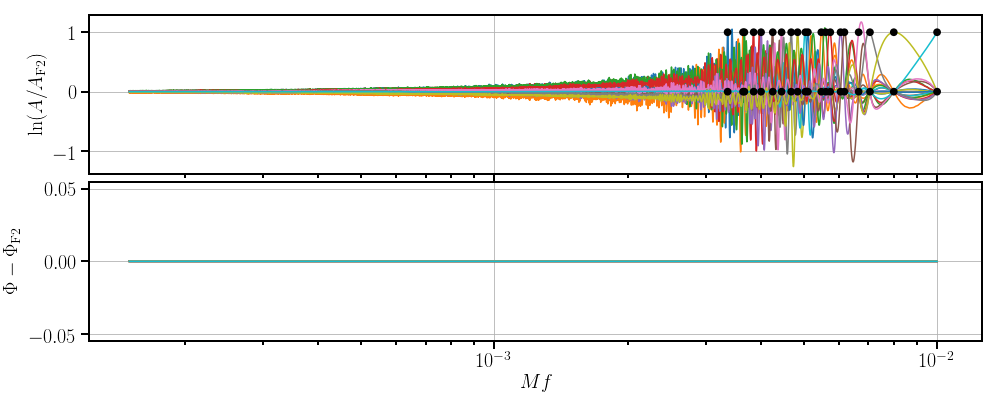

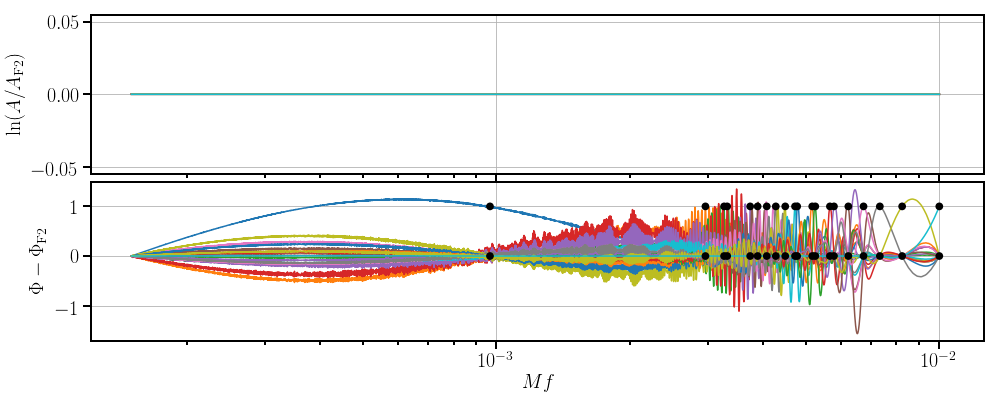

In [17]:
hs = [Bamp_j[j] for j in range(len(Bamp_j))]
mfs = np.array([Bamp_j.get_waveform(j, data='parameters')[0] for j in range(len(Bamp_j))])
fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
# zorder is order in which figure is drawn (placed on top of previous figures)
ax1.scatter(mfs, 0*mfs, marker='o', c='k', s=60, edgecolor='none', zorder=100)
ax1.scatter(mfs, 0*mfs+1, marker='o', c='k', s=60, edgecolor='none', zorder=100)

ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

hs = [Bphase_j[j] for j in range(len(Bphase_j))]
mfs = np.array([Bphase_j.get_waveform(j, data='parameters')[0] for j in range(len(Bphase_j))])
fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
# zorder is order in which figure is drawn (placed on top of previous figures)
ax2.scatter(mfs, 0*mfs, marker='o', c='k', s=60, edgecolor='none', zorder=100)
ax2.scatter(mfs, 0*mfs+1, marker='o', c='k', s=60, edgecolor='none', zorder=100)

ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Gaussian processes

In [18]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(Bamp_j)):
    mf = Bamp_j.get_waveform(j, data='parameters')[0]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(Bphase_j)):
    mf = Bphase_j.get_waveform(j, data='parameters')[0]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)
    
# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()

In [19]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'

damp_gp_list = []
for i in range(len(damp_ts_list)):
    print i
    points = params_ts
    data = damp_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    #print hp0
    print hyper_limits
    #print damp_gp.kernel_
    print gpr.get_hyperparameters(damp_gp)
    damp_gp_list.append(damp_gp)

0
[[  4.83736003e-03   1.93494401e-01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  4.83736003e-07   4.83736003e-03]]
[  3.73760813e-02   1.67996502e+00   3.80800971e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   1.99541146e-03]
1
[[  6.68676356e-03   2.67470542e-01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  6.68676356e-07   6.68676356e-03]]
[  4.24761272e-02   1.61778516e+00   3.58320115e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   3.01565637e-03]
2
[[  6.04902776e-03   2.41961110e-01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  6.04

In [20]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    print i
    points = params_ts
    data = dphase_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, sigma_n_factor=[1.0e-6, 0.1])
#     hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, 
#                                                              sigma_f_factor=[0.1, 10.0], 
#                                                              sigma_n_factor=[1.0e-5, 0.1], 
#                                                              length_scale_factor=[0.1, 10.0])
    dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    #print hp0
    print hyper_limits
    #print dphase_gp.kernel_
    print gpr.get_hyperparameters(dphase_gp)
    dphase_gp_list.append(dphase_gp)

0
[[  2.29661218e+00   9.18644871e+01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  2.29661218e-05   2.29661218e+00]]
[  1.04579398e+01   1.07651070e+00   3.06438664e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   2.29661218e-05]
1
[[  8.32958082e+00   3.33183233e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  8.32958082e-05   8.32958082e+00]]
[  3.09224630e+01   9.81495072e-01   3.84017017e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   8.32958082e-05]
2
[[  9.26661586e+00   3.70664635e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  9.26

In [21]:
filename = '../data/amp_gp_join_p00015.hdf5'
gp_list = damp_gp_list
kernel_type = 'matern52'
gpr.save_gaussian_process_regression_list(filename, gp_list, kernel_type)

filename = '../data/phase_gp_join_p00015.hdf5'
gp_list = dphase_gp_list
kernel_type = 'matern52'
gpr.save_gaussian_process_regression_list(filename, gp_list, kernel_type)

# Diagnosing GP fit

In [22]:
def symlog_yticks(axes):
    decade = np.array([0.1*i for i in range(10)])
    ticks = []
    for i in range(-1, 2):
        ticks.append(decade*10**i)
    ticks = np.concatenate(np.array(ticks))
    ticks_rev = np.flip(ticks, 0)
    all_ticks = np.concatenate((-ticks_rev, ticks)) 
    axes.set_yticks(all_ticks, minor=True)
    #axes.set_yticks(all_ticks)

In [23]:
dh_testset_uni = ws.HDF5WaveformSet('../data/dh_test_set_uniform_p00015.hdf5')

[  6.00000000e-01  -7.00000000e-01   2.00000000e-01   2.00000000e+03
   1.00000000e+03]


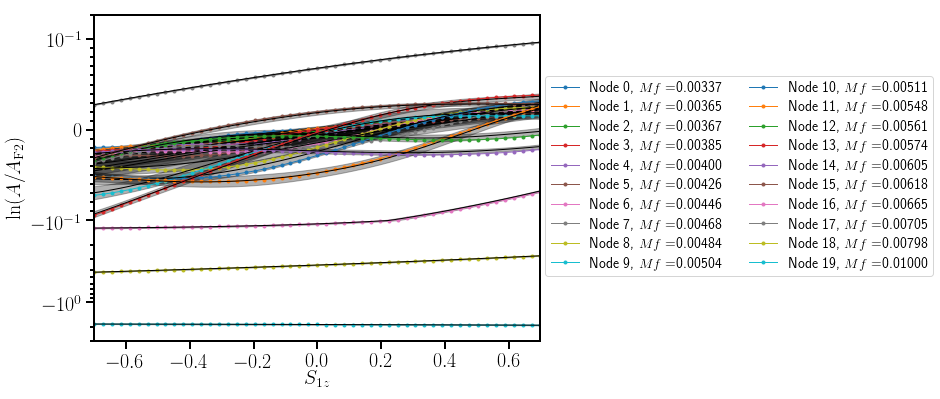

In [24]:
params_test = dh_testset_uni.parameters()
print params_test[0]

fig, axes = plt.subplots(1, figsize=(8, 6))
for j in range(len(damp_gp_list)):
    # Node frequency
    mf = Bamp_j.get_waveform(j, data='parameters')[0]
    
    # Values at node mf for test set and GP prediction/error
    damp_test = np.array([dh_testset_uni[i].interpolate('amp')(mf) for i in range(len(dh_testset_uni))])
    damp_gp = damp_gp_list[j]
    damp_gp_eval, damp_gp_eval_err = damp_gp.predict(params_test, return_std=True)
    
    axes.plot(params_test[:, 1], damp_test, 'o', ls='-', lw=1, ms=3,
             label='Node {}, $Mf=${:.5f}'.format(j, mf))
    axes.plot(params_test[:, 1], damp_gp_eval, ls='-', lw=1, c='k')
    axes.fill_between(params_test[:, 1], damp_gp_eval-damp_gp_eval_err, damp_gp_eval+damp_gp_eval_err, 
                      color='k', alpha=0.3)

axes.set_yscale('symlog', linthreshy=0.1)
#axes.set_yticks(ticks, minor=True)
symlog_yticks(axes)
axes.set_ylim(-3, 0.2)
axes.set_xlim(-0.7, 0.7)
axes.set_ylim()
axes.set_ylabel(r'$\ln(A/A_{\rm F2})$')
axes.set_xlabel(r'$S_{1z}$')
axes.legend(loc=(1.01, 0.2), ncol=2)

[  6.00000000e-01  -7.00000000e-01   2.00000000e-01   2.00000000e+03
   1.00000000e+03]


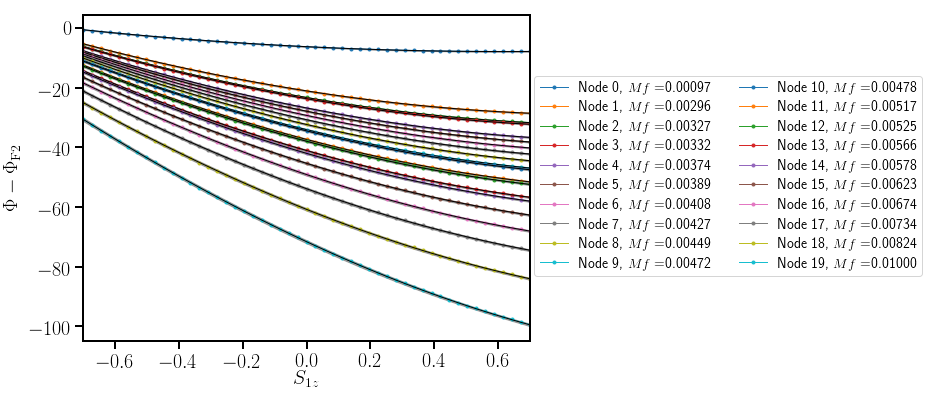

In [25]:
params_test = dh_testset_uni.parameters()
print params_test[0]

fig, axes = plt.subplots(1, figsize=(8, 6))
for j in range(len(dphase_gp_list)):
    # Node frequency
    mf = Bphase_j.get_waveform(j, data='parameters')[0]
    
    # Values at node mf for test set and GP prediction/error
    dphase_test = np.array([dh_testset_uni[i].interpolate('phase')(mf) for i in range(len(dh_testset_uni))])
    dphase_gp = dphase_gp_list[j]
    dphase_gp_eval, dphase_gp_eval_err = dphase_gp.predict(params_test, return_std=True)
    
    axes.plot(params_test[:, 1], dphase_test, 'o', ls='-', lw=1, ms=3,
             label='Node {}, $Mf=${:.5f}'.format(j, mf))
    axes.plot(params_test[:, 1], dphase_gp_eval, ls='-', lw=1, c='k')
    axes.fill_between(params_test[:, 1], dphase_gp_eval-dphase_gp_eval_err, dphase_gp_eval+dphase_gp_eval_err, 
                      color='k', alpha=0.3)

axes.set_xlim(-0.7, 0.7)
axes.set_ylim()
axes.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
axes.set_xlabel(r'$S_{1z}$')
axes.legend(loc=(1.01, 0.2), ncol=2)

# Diagnostics (Everything below should go in separate notebooks)

# Plot frequency dependent error estimates

In [167]:
Bamp_filename = '../data/Bamp.hdf5'
Bphase_filename = '../data/Bphase.hdf5'
damp_gp_filename = '../data/amp_gp.hdf5'
dphase_gp_filename = '../data/phase_gp.hdf5'

Bamp = ws.HDF5WaveformSet(Bamp_filename)
Bphase = ws.HDF5WaveformSet(Bphase_filename)
damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)

In [168]:
def error_of_frequency(point, B_j, gp_list, data='amp'):
    jmax = len(B_j)
    eps_f_j = np.array([gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                        for j in range(jmax)])
    
    # Get complex version of B_j's in array form
    if data=='amp':
        B_j_array = np.array([B_j[j].amp for j in range(jmax)])
    elif data=='phase':
        B_j_array = np.array([B_j[j].phase for j in range(jmax)])
    else:
        raise Exception

    # Evaluate waveform
    error_arr = np.dot(eps_f_j, B_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = B_j[0].x
    return xarr, error_arr

In [177]:
point = np.array([0.8, 0.3, 0.7, 3455, 2579])
f, eps = error_of_frequency(point, Bamp, damp_gp_list, data='amp')
#f, eps = error_of_frequency(point, Bphase, dphase_gp_list, data='phase')

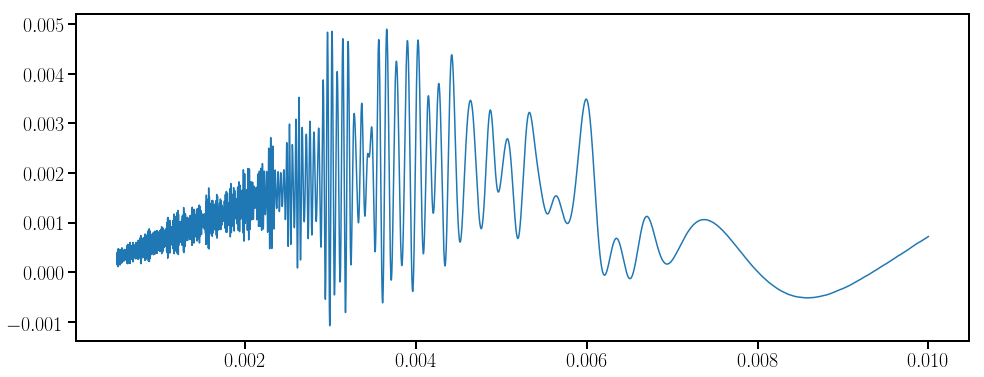

In [178]:
fig, ax1 = plt.subplots(1, figsize=(16, 6))
ax1.plot(f, eps)
#ax1.set_xscale('log')
#ax1.set_xlim(1.0e-4, 0.1)

0.00304761357728


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/lackey/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


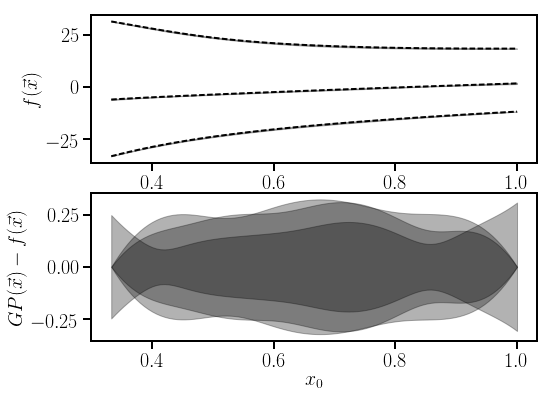

In [184]:
#x2, x3, x4 = 0.0, 2000.0, 2000.0
#x0, x1, x2, x3, x4 = params_rand[i_phasemax]
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0.0, 0.0
i = 2
mf = Bphase_j.get_waveform(i, data='parameters')[0]
print mf
gp = dphase_gp_list[i]

fig, ax = plt.subplots(2, figsize=(8, 6))
for x1 in np.linspace(-0.7, 0.7, 3):
    x0s = np.linspace(1.0/3.0, 1.0, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in x0s])
    
    #true = np.array([func(p) for p in ps])
    #ax[0].plot(xs, true, label=r'$x_1$='+str(x1))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(x0s, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(x0s, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    #ax[1].plot(x0s, (y_pred-true), label=r'$x_1$='+str(x1))
    ax[1].fill_between(x0s, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))